In [1]:
import re
import nrrd
import random
import os, glob
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify

import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from tensorflow.keras import layers
import segmentation_models_3D as sm
from keras.layers.merge import add,multiply
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from keras.layers import Activation, MaxPool2D, Concatenate, Add
from tensorflow.keras.utils import plot_model

from ipywidgets import interact, interactive, IntSlider, ToggleButtons

Segmentation Models: using `tf.keras` framework.


In [2]:
print(tf.keras.__version__)
print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

2.8.0
2.8.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Loss Function and coefficients to be used during training:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def loss(y_true, y_pred): # Segmentation Loss (Weighted Sum of Dice and IoU Losses)
    return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

#Define parameters for our model.
n_classes = 1
patch_size = 32
channels = 3

LR = 0.001
opt = tf.keras.optimizers.Nadam(LR)

In [9]:
BACKBONE = 'inceptionresnetv2' 
encoder_weights = 'imagenet'
activation = 'sigmoid' # Sigmoid for binary classification

model = sm.Unet(BACKBONE, classes = 1,
input_shape = (64, 64, 32, 3),
encoder_weights = encoder_weights,
activation = activation)

LR = 0.0001
opt = tf.keras.optimizers.Nadam(LR)

In [10]:
model.compile(optimizer = opt, loss = [loss], metrics = [dice_coef, iou_coef])
print(model.summary())


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 32,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 32, 32, 16,   2592        ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16,   96         ['conv3d[0][0]']                 
 alization)                     32)                                                         

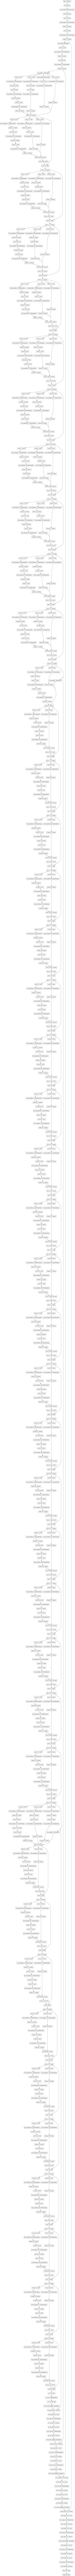

In [11]:
plot_model(model, to_file='inceptionresnetv2.png')